In [1]:
import astropy.coordinates as coord
import astropy.units as u
import h5py
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
scan_law_file = (
    "/mnt/ceph/users/gaia/scanninglaw/FullGaiaMissionScanningLaw/commanded_scan_law.csv"
)
raw_df = pd.read_csv(
    scan_law_file,
    comment="#",
)
print(f"...done - loaded {len(raw_df):,} rows")

...done - loaded 34,504,372 rows


In [3]:
len(raw_df), (raw_df.memory_usage().sum() * u.byte).to(u.gigabyte)

(34504372, <Quantity 4.41655975 Gbyte>)

In [4]:
raw_df.columns

Index(['jd_time', 'bjd_fov1', 'bjd_fov2', 'ra_fov1', 'dec_fov1',
       'heal_pix_fov1', 'scan_angle_fov1', 'parallax_factor_al_fov1',
       'parallax_factor_ac_fov1', 'ra_fov2', 'dec_fov2', 'heal_pix_fov2',
       'scan_angle_fov2', 'parallax_factor_al_fov2', 'parallax_factor_ac_fov2',
       'solution_id'],
      dtype='object')

In [105]:
# Turn the DataFrame where each row is a unique time for both FOVs into a new
# DataFrame with one row per scan sample and an FOV indicator column
new_data = {}
for col_name, col_data in raw_df.items():
    if "fov1" in col_name:
        base_name = col_name[:-5]
        new_data[base_name] = np.concatenate(
            (col_data.to_numpy(), raw_df[f"{base_name}_fov2"].to_numpy())
        )

        if "fov" not in new_data:
            new_data["fov"] = np.concatenate(
                (
                    np.full(col_data.size, 1, dtype=np.uint8),
                    np.full(col_data.size, 2, dtype=np.uint8),
                )
            )

    elif "fov2" in col_name:
        continue
    else:
        new_data[col_name] = np.concatenate((col_data.to_numpy(), col_data.to_numpy()))

df = pd.DataFrame(new_data)
mask = np.isfinite(df["ra"]) & np.isfinite(df["dec"])
df = df[mask].reset_index(drop=True)

df["time_bjd"] = df["bjd"]

# df["ra"] += 55.25234
# df["ra"] = df["ra"] % 360.0

In [217]:
nside = 100

In [218]:
GAIA_TIME_ORIGIN_JD = 2455197.5
# bjd_range = (2456892.376, 2457901.865)  # Gaia DR3
bjd_range = (2457901.865 - 180, 2457901.865)
# bjd_range = (2456892.376, 2456892.376 + 365)  # Gaia DR3

time_window_mask = (df["bjd"] >= (bjd_range[0] - GAIA_TIME_ORIGIN_JD)) & (
    df["bjd"] <= (bjd_range[1] - GAIA_TIME_ORIGIN_JD)
)
window_df = df[time_window_mask].reset_index(drop=True)

# ---
# Interpolate to a finer time sampling
interps = []
for fov in [1, 2]:
    fov_df = window_df[window_df["fov"] == fov]
    jd = fov_df["jd_time"].to_numpy()
    tmp = pd.DataFrame(
        {
            "jd_time": np.arange(
                jd.min(), jd.max() + 1e-5, np.diff(window_df["jd_time"])[0] / 10
            )
        }
    )
    tmp["fov"] = fov
    for colname in [
        "bjd",
        "scan_angle",
        "parallax_factor_al",
        "parallax_factor_ac",
    ]:
        tmp[colname] = np.interp(tmp["jd_time"], xp=jd, fp=fov_df[colname].to_numpy())

    _ra = np.deg2rad(fov_df["ra"].to_numpy())
    _dec = np.deg2rad(fov_df["dec"].to_numpy())
    xyz = np.stack(
        [
            np.cos(_ra) * np.cos(_dec),
            np.sin(_ra) * np.cos(_dec),
            np.sin(_dec),
        ],
        axis=0,
    )
    interp_xyz = np.stack(
        [
            np.interp(tmp["jd_time"], xp=jd, fp=xyz[0, :]),
            np.interp(tmp["jd_time"], xp=jd, fp=xyz[1, :]),
            np.interp(tmp["jd_time"], xp=jd, fp=xyz[2, :]),
        ],
        axis=0,
    )
    interp_xyz /= np.linalg.norm(interp_xyz, axis=0)
    interp_ra = np.rad2deg(np.arctan2(interp_xyz[1, :], interp_xyz[0, :])) % 360.0
    interp_dec = np.rad2deg(np.arcsin(interp_xyz[2, :]))
    tmp["ra"] = interp_ra
    tmp["dec"] = interp_dec

    interps.append(tmp)

window_df = pd.concat(interps).reset_index(drop=True)
window_df["time_bjd"] = window_df["bjd"]
# ---

# Compute HEALPix pixels for valid observations
pix = hp.ang2pix(
    nside,
    window_df["ra"].to_numpy(),
    window_df["dec"].to_numpy(),
    nest=False,
    lonlat=True,
)

In [219]:
# Find two high dec pixels on either side of ra=0 (four pixels total)
scans_ra, scans_dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
scans_ra[scans_ra >= 180] -= 360

_mask = (scans_dec > 60) & (scans_dec < 65)
val = scans_dec[_mask].min()
_mask = np.isclose(scans_dec, val)
check_idx = np.where(_mask & (np.abs(scans_ra) < 10))[0]
# check_idx = np.where(_mask & (np.abs(scans_ra) < 5))[0]
check_idx = check_idx[np.argsort(scans_ra[check_idx])]
print(check_idx)

[8057 8058 8059 8060 8061 8062 8063 7812 7813 7814 7815 7816 7817 7818]


In [220]:
pix_dfs = [window_df[pix == idx].reset_index(drop=True) for idx in check_idx]

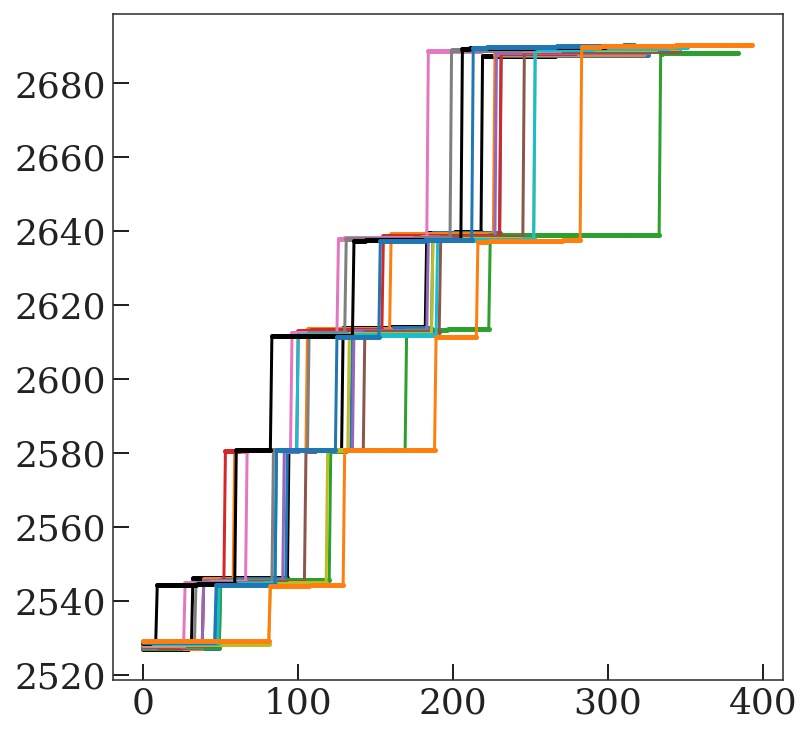

In [221]:
for pix_df in pix_dfs:
    plt.plot(np.sort(pix_df["bjd"].to_numpy()))

In [222]:
ROUGH_FOCAL_PLANE_TRANSIT_TIME = 0.000694


def _get_subset(subset):
    subset = subset.iloc[np.argsort(subset["time_bjd"])]
    if len(subset) == 0:
        return subset
    time_diffs = np.diff(subset["time_bjd"].to_numpy())
    large_gaps = time_diffs >= ROUGH_FOCAL_PLANE_TRANSIT_TIME
    # scan_start_indices = np.concatenate([[0], np.where(large_gaps)[0] + 1])
    # return subset.iloc[scan_start_indices]

    scan_end_indices = np.concatenate([np.where(large_gaps)[0], [len(subset) - 1]])
    return subset.iloc[scan_end_indices]

In [223]:
sub_dfs = [_get_subset(dd) for dd in pix_dfs]
counts = [len(sub_df) for sub_df in sub_dfs]
counts

[13, 10, 12, 14, 12, 11, 11, 14, 13, 17, 16, 17, 15, 17]

In [224]:
corners = np.swapaxes(hp.boundaries(nside, check_idx), 0, 1)  # (3, N, 4 sides)
rep = coord.CartesianRepresentation(corners)
sph = rep.represent_as(coord.SphericalRepresentation)

corners_lon = sph.lon.wrap_at(180 * u.deg).degree
corners_lat = sph.lat.degree

In [225]:
scan_tracks = {}
for j in [1, 2]:
    # for j in [1]:
    fov_mask = window_df["fov"] == j

    scan_track = coord.UnitSphericalRepresentation(
        lon=window_df[fov_mask]["ra"].to_numpy() * u.deg,
        lat=window_df[fov_mask]["dec"].to_numpy() * u.deg,
    )

    wrap_idx = np.where(
        np.abs(np.diff(scan_track.lon.wrap_at(180 * u.deg).degree)) > 359
    )[0]

    tmp_lon = scan_track.lon.degree.copy()
    tmp_lon[wrap_idx] = np.nan
    tmp_lat = scan_track.lat.degree.copy()
    tmp_lat[wrap_idx] = np.nan

    scan_tracks[j] = coord.UnitSphericalRepresentation(
        lon=tmp_lon * u.deg, lat=tmp_lat * u.deg
    )

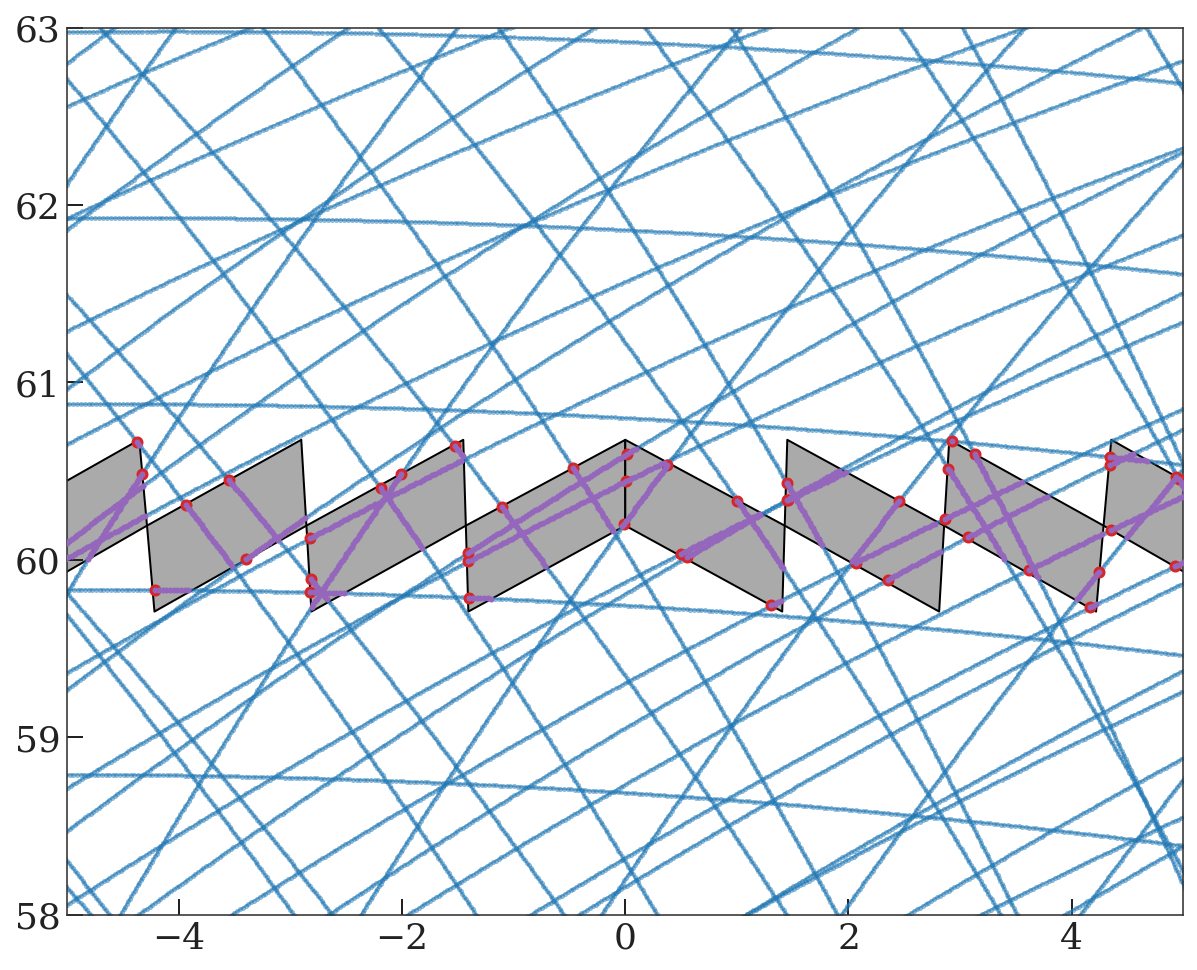

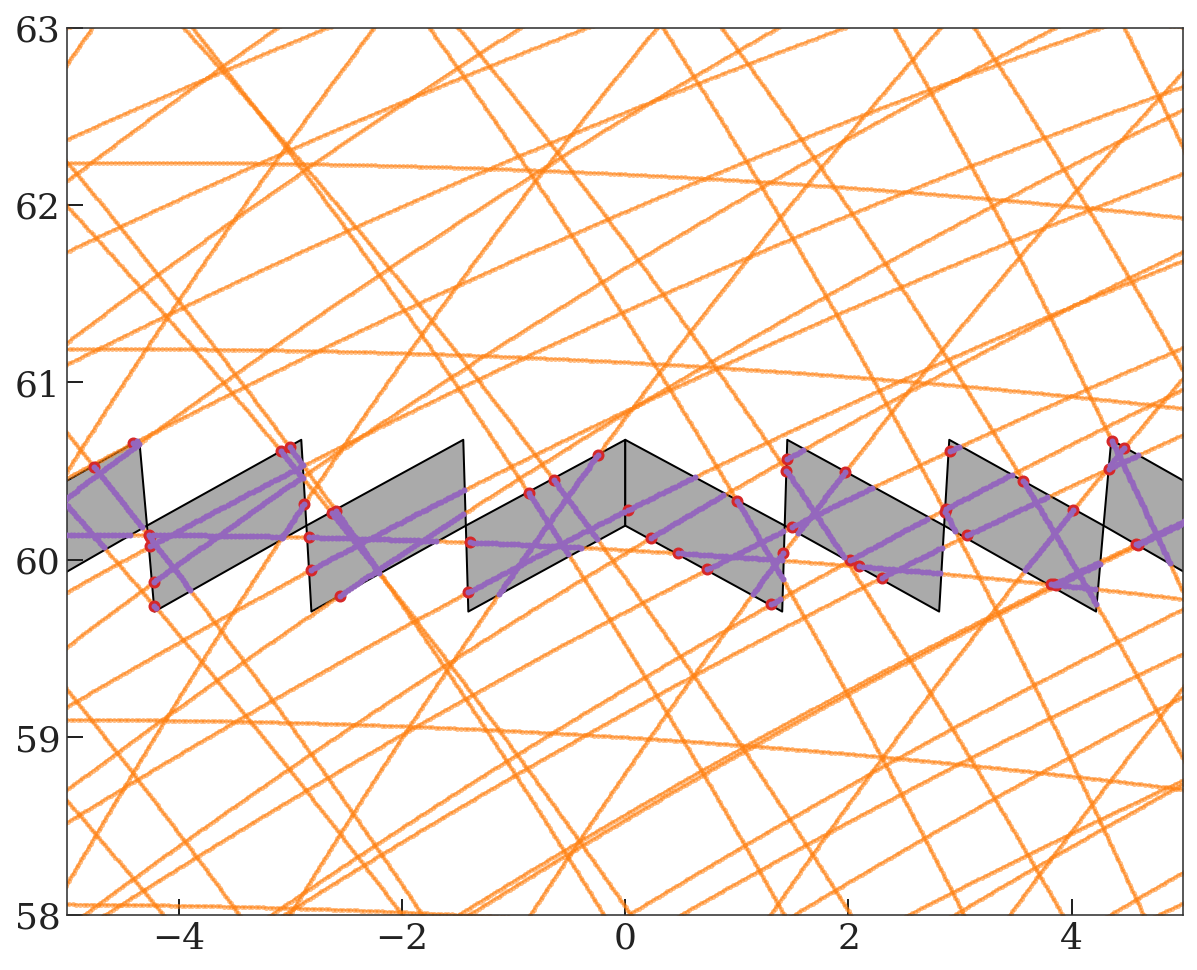

In [226]:
for (fov, scan_track), color in zip(
    scan_tracks.items(), ["tab:blue", "tab:orange"], strict=True
):
    polys = []
    for i in range(corners_lon.shape[0]):
        poly = mpl.patches.Polygon(np.stack((corners_lon[i], corners_lat[i]), axis=1))
        polys.append(poly)
    coll = mpl.collections.PatchCollection(polys, color="#aaaaaa", edgecolor="k")

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.add_collection(coll)
    ax.plot(
        scan_track.lon.wrap_at(180 * u.deg).degree,
        scan_track.lat.degree,
        color=color,
        lw=1,
        alpha=0.5,
        marker=".",
    )

    for pix_df in pix_dfs:
        ax.plot(
            coord.Angle(pix_df["ra"][pix_df["fov"] == fov], "deg")
            .wrap_at(180 * u.deg)
            .degree,
            pix_df["dec"][pix_df["fov"] == fov],
            color="tab:purple",
            ls="none",
            ms=6.0,
            zorder=1000,
        )

    for sub_df in sub_dfs:
        sub_df = sub_df[sub_df["fov"] == fov]
        ax.scatter(
            coord.Angle(sub_df["ra"], "deg").wrap_at(180 * u.deg).degree,
            sub_df["dec"],
            color="tab:red",
            zorder=100,
        )

    buffer = 5
    ax.set_xlim(-buffer, buffer)
    ax.set_ylim(60.5 - buffer / 2, 60.5 + buffer / 2)